# Masinsko ucenje - projekat

Dataset: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
 
Klasifikacija - Predviđanje ponovne hospitalizacije pacijenta sa dijabetesom na osnovu podataka sa inicijalne hospitalizacije

1.   Priprema podataka

In [25]:
import pandas as pd
import sklearn as scikit
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder
import copy
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold
from math import ceil
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif


In [26]:
path = "../dataset/diabetic_data.csv"
dataframe = pd.read_csv(path, low_memory=False, na_values=[
                        "?", "Unknown/Invalid"])
pd.set_option("display.max_columns", None)
dataframe.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [27]:
dataframe.shape

(101766, 50)

In [28]:
dataframe["readmitted"].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [29]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [30]:
def get_null_col(df, treshold):
    missing = df.isna()
    missing_count = missing.sum()
    total_rows=df.shape[0]
    to_drop = []
    for i in range(0, missing_count.count()):
        if missing_count[i] / total_rows > treshold:
            to_drop.append(i)
    return to_drop

for i in get_null_col(dataframe, 0.1):
    print(dataframe.columns[i])

#dataframe = dataframe.drop(dataframe.columns[to_drop], axis=1)


weight
payer_code
medical_specialty


In [31]:
dataframe["medical_specialty"].fillna("Unknown", inplace=True)
dataframe["payer_code"].fillna("Unknown", inplace=True)
dataframe["weight"].value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

In [32]:
weigth_scale_mapper = {
    "[0-25)": 0 
    ,"[25-50)": 1
    ,"[50-75)": 2
    ,"[75-100)": 3
    ,"[100-125)": 4
    ,"[125-150)": 5
    ,"[150-175)": 6
    ,"[175-200)": 7
    ,">200": 8
}
dataframe["weight"].replace(weigth_scale_mapper, inplace=True)
dataframe["weight"].fillna(round(dataframe["weight"].mean()), inplace=True)


In [33]:
print(dataframe.shape)
dataframe.dropna(inplace=True)
to_drop = ["encounter_id",]
dataframe.drop(
    dataframe[to_drop],
    axis=1,
    inplace=True,
)
dataframe.shape

(101766, 50)


(98052, 49)

In [34]:
def get_one_value_cols(df):
    to_drop=[]
    for col in df.columns:
        if len(df[col].unique()) == 1:
            print(col)
            to_drop.append(col)
    return to_drop

dataframe.drop(get_one_value_cols(dataframe),axis=1,inplace=True)

examide
citoglipton
metformin-rosiglitazone


In [35]:
print("Number Of Rows In The Original DataFrame:", len(dataframe))
print("Number Of Rows After Deduping:", len(dataframe.drop_duplicates()))

Number Of Rows In The Original DataFrame: 98052
Number Of Rows After Deduping: 98052


In [36]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patient_nbr               98052 non-null  int64  
 1   race                      98052 non-null  object 
 2   gender                    98052 non-null  object 
 3   age                       98052 non-null  object 
 4   weight                    98052 non-null  float64
 5   admission_type_id         98052 non-null  int64  
 6   discharge_disposition_id  98052 non-null  int64  
 7   admission_source_id       98052 non-null  int64  
 8   time_in_hospital          98052 non-null  int64  
 9   payer_code                98052 non-null  object 
 10  medical_specialty         98052 non-null  object 
 11  num_lab_procedures        98052 non-null  int64  
 12  num_procedures            98052 non-null  int64  
 13  num_medications           98052 non-null  int64  
 14  numbe

Diagnose mapping http://icd9cm.chrisendres.com/index.php?action=contents

In [37]:
def diag_mapper(value: str) -> int:
    try:
        int_value = int(float(value))
        if int_value <= 139:
            return 'Infectious and Parasitic'
        elif int_value <= 239:
            return 'Neoplasms'
        elif int_value <= 279:
            return 'Metabolic'
        elif int_value <= 289:
            return 'Blood'
        elif int_value <= 319:
            return 'Mental'
        elif int_value <= 389:
            return 'Nervous System'
        elif int_value <= 459:
            return 'Circulatory System'
        elif int_value <= 519:
            return 'Respiratory System'
        elif int_value <= 579:
            return 'Digestive System'
        elif int_value <= 629:
            return 'Genitourinary System'
        elif int_value <= 679:
            return 'Pregnancy'
        elif int_value <= 709:
            return 'Skin'
        elif int_value <= 739:
            return 'Musculoskeletal'
        elif int_value <= 759:
            return 'Congenital'
        elif int_value <= 779:
            return 'Perinatal Period'
        elif int_value <= 799:
            return 'Ill Defined'
        else:
            return 'Injury'
    except ValueError:
        if value[0] == 'V':
            return 'Status'
        else:  # E
            return 'Cause'


dataframe['diag_1_class'] = dataframe['diag_1'].apply(lambda x: diag_mapper(x))
dataframe['diag_2_class'] = dataframe['diag_2'].apply(lambda x: diag_mapper(x))
dataframe['diag_3_class'] = dataframe['diag_3'].apply(lambda x: diag_mapper(x))


In [38]:
glu_scale_mapper = {
    'None': 0,
    'Norm': 1,
    '>200': 2,
    '>300': 3
}
a1_scale_mapper = {
    'None': 0,
    'Norm': 1,
    '>7': 2,
    '>8': 3,
}
class_mapper = {
    'NO':0,
    '<30':1,
    '>30':2
}

one_hot = LabelBinarizer()
lab_enc = LabelEncoder()

dataframe['admission_type_id'] = dataframe['admission_type_id'].astype('category')
dataframe['discharge_disposition_id'] = dataframe['discharge_disposition_id'].astype('category')
dataframe['admission_source_id'] = dataframe['admission_source_id'].astype('category')
dataframe['weight'] = dataframe['weight'].astype('int32')

dataframe['age']=lab_enc.fit_transform(dataframe['age'])
dataframe['gender'] = one_hot.fit_transform(dataframe['gender'])
dataframe['max_glu_serum'].replace(glu_scale_mapper, inplace=True)
dataframe['A1Cresult'].replace(a1_scale_mapper, inplace=True)
dataframe['medical_specialty']=lab_enc.fit_transform(dataframe['medical_specialty'])

lab_coded = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
    'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
    'tolazamide','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-pioglitazone'
    ,'diag_1','diag_2','diag_3','payer_code']

for col in lab_coded:
    dataframe[col] = lab_enc.fit_transform(dataframe[col])

dataframe['change'] = one_hot.fit_transform(dataframe['change'])
dataframe['diabetesMed'] = one_hot.fit_transform(dataframe['diabetesMed'])

dataframe['readmitted'].replace(class_mapper, inplace=True)

dataframe.head()

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_class,diag_2_class,diag_3_class
1,55629189,Caucasian,0,1,3,1,1,7,3,15,71,59,0,18,0,0,0,143,77,121,9,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,1,2,Metabolic,Metabolic,Metabolic
2,86047875,AfricanAmerican,0,2,3,1,1,7,2,15,71,11,5,13,2,0,1,454,76,763,6,0,0,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,1,1,0,0,0,1,1,0,Pregnancy,Metabolic,Status
3,82442376,Caucasian,1,3,3,1,1,7,2,15,71,44,1,16,0,0,0,553,95,248,7,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,3,1,0,0,0,0,1,0,Infectious and Parasitic,Metabolic,Circulatory System
4,42519267,Caucasian,1,4,3,1,1,7,1,15,71,51,0,8,0,0,0,54,23,86,5,0,0,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,2,1,0,0,0,0,1,0,Neoplasms,Neoplasms,Metabolic
5,82637451,Caucasian,1,5,3,2,1,2,3,15,71,31,6,16,0,0,0,263,244,86,9,0,0,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,2,1,0,0,0,1,1,2,Circulatory System,Circulatory System,Metabolic


In [39]:
dataframe_label = dataframe
dataframe_onehot = dataframe.copy(deep=True)
dataframe_onehot_plus = dataframe.copy(deep=True)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   patient_nbr               98052 non-null  int64   
 1   race                      98052 non-null  object  
 2   gender                    98052 non-null  int32   
 3   age                       98052 non-null  int32   
 4   weight                    98052 non-null  int32   
 5   admission_type_id         98052 non-null  category
 6   discharge_disposition_id  98052 non-null  category
 7   admission_source_id       98052 non-null  category
 8   time_in_hospital          98052 non-null  int64   
 9   payer_code                98052 non-null  int32   
 10  medical_specialty         98052 non-null  int32   
 11  num_lab_procedures        98052 non-null  int64   
 12  num_procedures            98052 non-null  int64   
 13  num_medications           98052 non-null  int

In [40]:

def df_one_hot(df, columns):
    tmp = pd.DataFrame()
    for col in columns:
        res = one_hot.fit_transform(df[col])
        for val in range(0, len(res[0])):
            new_col = res[:, val]
            tmp_col = pd.DataFrame(
                {col + '(' + str(one_hot.classes_[val])+')': new_col})
            tmp = pd.concat((tmp, tmp_col), axis=1)
    return pd.concat((df.reset_index(drop=True), tmp.reset_index(drop=True)), axis=1, join='inner')

for col in ['diag_1_class', 'diag_2_class', 'diag_3_class','race']:
    dataframe_label[col] = lab_enc.fit_transform(dataframe_label[col])

dataframe_onehot_plus = df_one_hot(dataframe_onehot_plus, ['diag_1_class', 'diag_2_class', 'diag_3_class',
                              'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'race'])
dataframe_onehot_plus.drop(['diag_1_class', 'diag_2_class', 'diag_3_class', 'admission_type_id',
                      'discharge_disposition_id', 'admission_source_id', 'race'], axis=1, inplace=True)

dataframe_onehot = df_one_hot(dataframe_onehot, ['diag_1_class', 'diag_2_class', 'diag_3_class','race'])
dataframe_onehot.drop(['diag_1_class', 'diag_2_class', 'diag_3_class','race'], axis=1, inplace=True)


print(dataframe_label.shape)
print(dataframe_onehot_plus.shape)
print(dataframe_onehot.shape)

(98052, 49)
(98052, 152)
(98052, 104)


In [41]:
def remove_low_variance_columns(df, target, treshold):

    y = df[target]
    X_cat = df.drop(columns=[target,])
    selector = VarianceThreshold(threshold=treshold)
    X_reduced = selector.fit_transform(X_cat, y)
    cols = selector.get_support(indices=True)
    selected_columns = X_cat.iloc[:, cols].columns.tolist()
    selected_columns.append(target)
    print(X_reduced.shape)
    return selected_columns


# selected_columns = remove_low_variance_columns(
#     dataframe_onehot, "readmitted", 0.005)

# to_drop = []
# print("deleted columns:")

# for col in dataframe_onehot.columns:
#     if col not in selected_columns:
#         print(col)
#         to_drop.append(col)

# # dataframe_onehot.drop(dataframe_onehot[to_drop], inplace=True, axis=1)
# print(dataframe_onehot.shape)


In [42]:
def select_best_columns(df, target, best_ratio):

    y = df[target]
    X_cat = df.drop(columns=[target, 'diag_1', 'diag_2', 'diag_3'])
    X = X_cat
    selector = SelectKBest(mutual_info_classif, k=ceil(X.shape[1]*best_ratio))
    X_reduced = selector.fit_transform(X, y)
    cols = selector.get_support(indices=True)
    selected_columns = X.iloc[:, cols].columns.tolist()
    selected_columns.append(target)

    print(X_reduced.shape)

    return selected_columns


# selected = select_best_columns(dataframe_onehot, "readmitted", 0.8)

# to_drop = []
# print("deleted columns:")

# for col in dataframe_onehot.columns:
#     if col not in selected:
#         print(col)
#         to_drop.append(col)

# #dataframe_onehot.drop(dataframe_onehot[to_drop], inplace=True, axis=1)
# print(dataframe_onehot.shape)


2.   Deskriptivna analiza

<AxesSubplot: ylabel='readmitted'>

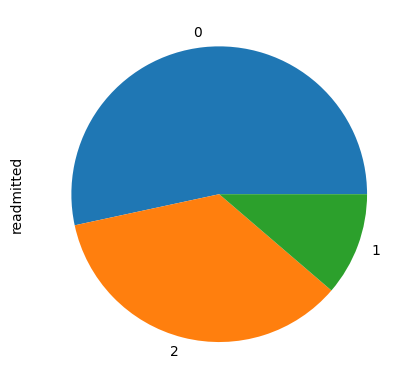

In [54]:
dataframe_onehot['readmitted'].value_counts().plot(kind='pie')

In [44]:
def feature_importance(df):
    target = 'readmitted'
    y = df[target]
    X = df.drop(columns=[target, 'diag_1', 'diag_2', 'diag_3'])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2, random_state=1066)
    encoder = ce.LeaveOneOutEncoder(return_df=True)
    X_train_loo = encoder.fit_transform(X_train, y_train)
    X_test_loo = encoder.transform(X_test)
    model = GradientBoostingRegressor(
        learning_rate=0.05, max_depth=5, n_estimators=500, min_samples_split=5, n_iter_no_change=10)
    model.fit(X_train_loo, y_train)

    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_loo)))
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(20, 30))
    plt.barh(range(len(sorted_idx)),
             feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('Feature Importance')

    perm_importance = permutation_importance(
        model, X_test_loo, y_test, n_repeats=10, random_state=1066)
    sorted_idx = perm_importance.importances_mean.argsort()
    fig = plt.figure(figsize=(20, 30))
    plt.barh(range(len(sorted_idx)),
             perm_importance.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('Permutation Importance')
    

# feature_importance(dataframe_onehot)


3. Algoritmi za klasifikaciju

k-Nearest Neighbors.
Decision Trees.
Naive Bayes.
Random Forest.
Gradient Boosting.

In [68]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer

In [46]:
dataframe_onehot.describe()

,patient_nbr,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_class(Blood),diag_1_class(Cause),diag_1_class(Circulatory System),diag_1_class(Congenital),diag_1_class(Digestive System),diag_1_class(Genitourinary System),diag_1_class(Ill Defined),diag_1_class(Infectious and Parasitic),diag_1_class(Injury),diag_1_class(Mental),diag_1_class(Metabolic),diag_1_class(Musculoskeletal),diag_1_class(Neoplasms),diag_1_class(Nervous System),diag_1_class(Pregnancy),diag_1_class(Respiratory System),diag_1_class(Skin),diag_1_class(Status),diag_2_class(Blood),diag_2_class(Cause),diag_2_class(Circulatory System),diag_2_class(Congenital),diag_2_class(Digestive System),diag_2_class(Genitourinary System),diag_2_class(Ill Defined),diag_2_class(Infectious and Parasitic),diag_2_class(Injury),diag_2_class(Mental),diag_2_class(Metabolic),diag_2_class(Musculoskeletal),diag_2_class(Neoplasms),diag_2_class(Nervous System),diag_2_class(Pregnancy),diag_2_class(Respiratory System),diag_2_class(Skin),diag_2_class(Status),diag_3_class(Blood),diag_3_class(Cause),diag_3_class(Circulatory System),diag_3_class(Congenital),diag_3_class(Digestive System),diag_3_class(Genitourinary System),diag_3_class(Ill Defined),diag_3_class(Infectious and Parasitic),diag_3_class(Injury),diag_3_class(Mental),diag_3_class(Metabolic),diag_3_class(Musculoskeletal),diag_3_class(Neoplasms),diag_3_class(Nervous System),diag_3_class(Pregnancy),diag_3_class(Respiratory System),diag_3_class(Skin),diag_3_class(Status),race(AfricanAmerican),race(Asian),race(Caucasian),race(Hispanic),race(Other)
count,9.805200e+04,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.00000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,5.484745e+07,0.461174,6.126025,2.998613,4.422011,9.696845,46.065435,43.148462,1.350712,16.119590,0.376382,0.202464,0.646871,337.624240,274.955085,280.592114,7.512096,0.092920,0.358616,1.195407,1.015706,1.007057,1.000887,1.050320,0.000010,1.121905,1.101742,0.000224,1.072349,1.062946,1.003090,1.000316,0.000031,0.000388,1.401042,1.006823,0.000133,0.000010,0.000010,0.538225,0.768470,0.819606,0.011004,0.000010,0.301157,0.000510,0.091054,0.050453,0.075746,0.027424,0.068362,0.021876,0.107667,0.048331,0.033778,0.011932,0.006578,0.102935,0.024864,0.016318,0.029046,0.007302,0.312100,0.001050,0.039265,0.079845,0.045812,0.019061,0.02374

In [60]:
def gridSearch(df, target, search_space, metric):

    np.random.seed(0)
    scores = []
    start = timer()
    for model_name, mp in search_space.items():
        clf = GridSearchCV(mp['model'], mp['params'], scoring=metric, cv=2, return_train_score=False, verbose=True)
        clf.fit(df.drop(columns=[target]).values, df[target].values)
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
        print(int(timer() - start))
    return scores


In [61]:
search_space = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 20]  # [1,5,10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'penalty': ['l1',],
            'C': [1, 5]
        }
    },
    'knn': {
        'model': KNeighborsClassifier(algorithm='auto'),
        'params': {
            'n_neighbors': [15,],
            'leaf_size': [40,],
            'p': [1, 2],
            'weights': ['uniform', 'distance']
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini'],
            'max_depth': [50]
        }
    },
    'naive_bayes': {
        'model': MultinomialNB(),
        'params': {
        }
    },
    # 'gradient_boosting': {
    #     'model': GradientBoostingClassifier(),
    #     'params': {
    #         'learning_rate': [0.04],
    #         'subsample': [0.5,],
    #         'n_estimators': [100],
    #         'max_depth': [50]
    #     }
    # },
    'hist_gradient_boosting': {
        'model': HistGradientBoostingClassifier(),
        'params': {
            'max_iter': [100],
            'learning_rate': [0.4],
            'max_depth': [50],
            'l2_regularization': [1.5],
        }
    },

}


In [25]:
scores=gridSearch(dataframe_label, 'readmitted', search_space, metric='accuracy')
sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

Fitting 2 folds for each of 2 candidates, totalling 4 fits
15
Fitting 2 folds for each of 2 candidates, totalling 4 fits
61
Fitting 2 folds for each of 4 candidates, totalling 8 fits
1198
Fitting 2 folds for each of 1 candidates, totalling 2 fits
1203
Fitting 2 folds for each of 1 candidates, totalling 2 fits
1203
Fitting 2 folds for each of 1 candidates, totalling 2 fits
1207


,model,best_score,best_params
0,random_forest,0.532656,{'n_estimators': 20}
1,logistic_regression,0.539744,"{'C': 1, 'penalty': 'l1'}"
2,knn,0.480561,"{'leaf_size': 40, 'n_neighbors': 15, 'p': 1, '..."
3,decision_tree,0.463448,"{'criterion': 'gini', 'max_depth': 50}"
4,naive_bayes,0.364460,{}
5,hist_gradient_boosting,0.551197,"{'l2_regularization': 1.5, 'learning_rate': 0...."


In [ ]:
scores=gridSearch(dataframe_onehot, 'readmitted', search_space, metric='accuracy')
sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

In [27]:
scores=gridSearch(dataframe_onehot_plus, 'readmitted', search_space, metric='accuracy')
sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

Fitting 2 folds for each of 2 candidates, totalling 4 fits
18
Fitting 2 folds for each of 2 candidates, totalling 4 fits
115
Fitting 2 folds for each of 4 candidates, totalling 8 fits
2623
Fitting 2 folds for each of 1 candidates, totalling 2 fits
2633
Fitting 2 folds for each of 1 candidates, totalling 2 fits
2633
Fitting 2 folds for each of 1 candidates, totalling 2 fits
2645


,model,best_score,best_params
0,random_forest,0.533962,{'n_estimators': 20}
1,logistic_regression,0.543650,"{'C': 1, 'penalty': 'l1'}"
2,knn,0.480643,"{'leaf_size': 40, 'n_neighbors': 15, 'p': 1, '..."
3,decision_tree,0.467089,"{'criterion': 'gini', 'max_depth': 50}"
4,naive_bayes,0.380329,{}
5,hist_gradient_boosting,0.548291,"{'l2_regularization': 1.5, 'learning_rate': 0...."


In [29]:
selected_columns = remove_low_variance_columns(
    dataframe_label, "readmitted", 0.005)

to_drop = set()
print("deleted columns:")

for col in dataframe_label.columns:
    if col not in selected_columns:
        print(col)
        to_drop.add(col)

selected = select_best_columns(dataframe_label, "readmitted", 0.8)

for col in dataframe_label.columns:
    if col not in selected:
        print(col)
        to_drop.add(col)

scores=gridSearch(dataframe_label.drop(dataframe_label[list(to_drop)], axis=1), 'readmitted', search_space, metric='accuracy')
sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

(98052, 38)
deleted columns:
chlorpropamide
acetohexamide
tolbutamide
acarbose
miglitol
troglitazone
tolazamide
glipizide-metformin
glimepiride-pioglitazone
metformin-pioglitazone
(98052, 36)
gender
num_lab_procedures
diag_1
diag_2
diag_3
acetohexamide
tolbutamide
troglitazone
tolazamide
glipizide-metformin
glimepiride-pioglitazone
metformin-pioglitazone
Fitting 2 folds for each of 2 candidates, totalling 4 fits
11
Fitting 2 folds for each of 2 candidates, totalling 4 fits
36
Fitting 2 folds for each of 4 candidates, totalling 8 fits
903
Fitting 2 folds for each of 1 candidates, totalling 2 fits
907
Fitting 2 folds for each of 1 candidates, totalling 2 fits
907
Fitting 2 folds for each of 1 candidates, totalling 2 fits
911


,model,best_score,best_params
0,random_forest,0.532666,{'n_estimators': 20}
1,logistic_regression,0.540122,"{'C': 1, 'penalty': 'l1'}"
2,knn,0.480633,"{'leaf_size': 40, 'n_neighbors': 15, 'p': 2, '..."
3,decision_tree,0.465335,"{'criterion': 'gini', 'max_depth': 50}"
4,naive_bayes,0.345521,{}
5,hist_gradient_boosting,0.546537,"{'l2_regularization': 1.5, 'learning_rate': 0...."


Modifikacija dataset-a za binarnu klasifikaciju

<AxesSubplot: ylabel='readmitted'>

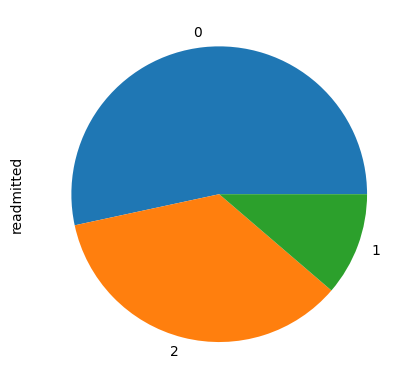

In [55]:
dataframe_label['readmitted'].value_counts().plot(kind='pie')

<AxesSubplot: ylabel='readmitted'>

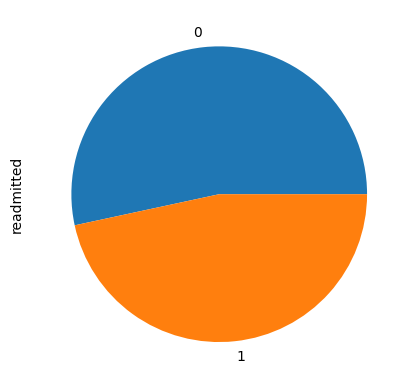

In [57]:
dataframe_label_binary=dataframe_label.copy(deep=True)
dataframe_onehot_binary=dataframe_onehot.copy(deep=True)
dataframe_onehot_plus_binary=dataframe_onehot_plus.copy(deep=True)

dataframe_label_binary['readmitted'].replace(to_replace=2,value=1,inplace=True)
dataframe_onehot_binary['readmitted'].replace(to_replace=2,value=1,inplace=True)
dataframe_onehot_plus_binary['readmitted'].replace(to_replace=2,value=1,inplace=True)

dataframe_label_binary['readmitted'].value_counts().plot(kind='pie')

In [62]:
scores=gridSearch(dataframe_label_binary, 'readmitted', search_space, metric='accuracy')
sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

Fitting 2 folds for each of 2 candidates, totalling 4 fits
13
Fitting 2 folds for each of 2 candidates, totalling 4 fits
53
Fitting 2 folds for each of 4 candidates, totalling 8 fits
839
Fitting 2 folds for each of 1 candidates, totalling 2 fits
844
Fitting 2 folds for each of 1 candidates, totalling 2 fits
844
Fitting 2 folds for each of 1 candidates, totalling 2 fits
850


,model,best_score,best_params
0,random_forest,0.596286,{'n_estimators': 20}
1,logistic_regression,0.585669,"{'C': 1, 'penalty': 'l1'}"
2,knn,0.531595,"{'leaf_size': 40, 'n_neighbors': 15, 'p': 1, '..."
3,decision_tree,0.557786,"{'criterion': 'gini', 'max_depth': 50}"
4,naive_bayes,0.517807,{}
5,hist_gradient_boosting,0.611992,"{'l2_regularization': 1.5, 'learning_rate': 0...."


In [63]:
scores=gridSearch(dataframe_onehot_binary, 'readmitted', search_space, metric='accuracy')
sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

Fitting 2 folds for each of 2 candidates, totalling 4 fits
14
Fitting 2 folds for each of 2 candidates, totalling 4 fits
34
Fitting 2 folds for each of 4 candidates, totalling 8 fits
1770
Fitting 2 folds for each of 1 candidates, totalling 2 fits
1779
Fitting 2 folds for each of 1 candidates, totalling 2 fits
1779
Fitting 2 folds for each of 1 candidates, totalling 2 fits
1789


,model,best_score,best_params
0,random_forest,0.594878,{'n_estimators': 20}
1,logistic_regression,0.590197,"{'C': 5, 'penalty': 'l1'}"
2,knn,0.531820,"{'leaf_size': 40, 'n_neighbors': 15, 'p': 1, '..."
3,decision_tree,0.560050,"{'criterion': 'gini', 'max_depth': 50}"
4,naive_bayes,0.517837,{}
5,hist_gradient_boosting,0.610931,"{'l2_regularization': 1.5, 'learning_rate': 0...."


In [64]:
scores=gridSearch(dataframe_onehot_plus_binary, 'readmitted', search_space, metric='accuracy')
sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

Fitting 2 folds for each of 2 candidates, totalling 4 fits
18
Fitting 2 folds for each of 2 candidates, totalling 4 fits
46
Fitting 2 folds for each of 4 candidates, totalling 8 fits
2324
Fitting 2 folds for each of 1 candidates, totalling 2 fits
2332
Fitting 2 folds for each of 1 candidates, totalling 2 fits
2332
Fitting 2 folds for each of 1 candidates, totalling 2 fits
2342


,model,best_score,best_params
0,random_forest,0.596133,{'n_estimators': 20}
1,logistic_regression,0.597275,"{'C': 1, 'penalty': 'l1'}"
2,knn,0.531748,"{'leaf_size': 40, 'n_neighbors': 15, 'p': 1, '..."
3,decision_tree,0.557500,"{'criterion': 'gini', 'max_depth': 50}"
4,naive_bayes,0.523885,{}
5,hist_gradient_boosting,0.610003,"{'l2_regularization': 1.5, 'learning_rate': 0...."


In [65]:
def randomSearch(df, target, search_space, scorings=['accuracy','f1','f1_micro','f1_macro','roc_auc_ovr','roc_auc_ovo','roc_auc','precision'], metric='f1'):
    np.random.seed(0)
    scores = []
    models = []
    for model_name, mp in search_space.items():
        clf = RandomizedSearchCV(mp['model'], mp['params'], scoring=scorings, refit=metric, cv=2, return_train_score=False, verbose=True,n_jobs=-1)
        best=clf.fit(df.drop(columns=[target]).values, df[target].values)
        models.append(best)
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
    return (scores,models)

In [72]:
search_space2 = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
            'max_features': ['auto', 'sqrt'],
            'max_depth' : list([int(x) for x in np.linspace(10, 110, num = 11)]),
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-4, 4, 20),
            'solver' : ['liblinear']
        }
    },
    'hist_gradient_boosting': {
        'model': HistGradientBoostingClassifier(),
        'params': {
            'max_iter': [1000,1200,1500],
            'learning_rate': [0.1],
            'max_depth': [25, 50, 75],
            'scoring': ['f1_micro'],
            'l2_regularization': [1.5]
        }
    }
}

In [73]:
scores, models=randomSearch(dataframe_label_binary, 'readmitted', search_space2)
sc = pd.DataFrame(scores,columns=['model','best_score','best_params'])
sc

Fitting 2 folds for each of 10 candidates, totalling 20 fits
